# Naive Bayes

In [129]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


In [130]:
# Loading data
data = pd.read_csv('game_details_with_counts.csv')


In [131]:
# Creating the 'cult_classic' feature
# Cult classic: high ratings (> 8) and high number of ratings (> 1000)
data['cult_classic'] = ((data['users_rated'] > 5000) & 
                        (data['average_rating'] > 8.0)).astype(int)

# Creating the 'game_night_game' feature
# Game night game: more than 4 players and high ratings (> 7)
data['game_night_game'] = ((data['max_players'] >= 4) & (data['average_rating'] > 7)).astype(int)

# Creating the 'high_complexity_game' feature
# High complexity game: high weight (> 3.5), long playtime (> 60 mins), more than 4 categories, and more than 4 mechanics
data['high_complexity_game'] = ((data['weight'] > 3.5) & 
                                 (data['max_playtime'] > 60) & 
                                 (data['category_count'] > 4) &
                                 (data['mechanic_count'] > 4)).astype(int)

# Creating the 'complexity_level' feature based on multiple factors
# Low complexity: low weight, short playtime, few categories, few mechanics
# Medium complexity: intermediate levels in criteria
# High complexity: high weight, long playtime, multiple categories and mechanics
conditions = [
    (data['weight'] <= 2) & (data['max_playtime'] <= 30) & (data['category_count'] <= 2) & (data['mechanic_count'] <= 2),
    (data['weight'] > 2) & (data['weight'] <= 3.5) & (data['max_playtime'] > 30) & (data['max_playtime'] <= 60) & 
    (data['category_count'] > 2) & (data['category_count'] <= 4) & (data['mechanic_count'] > 2) & (data['mechanic_count'] <= 4),
    (data['weight'] > 3.5) & (data['max_playtime'] > 60) & (data['category_count'] > 4) & (data['mechanic_count'] > 4)
]
choices = ['low', 'medium', 'high']
data['complexity_level'] = np.select(conditions, choices, default='medium')




In [132]:
print(data.columns)

Index(['name', 'year_published', 'min_players', 'max_players', 'min_playtime',
       'max_playtime', 'min_age', 'categories', 'mechanics', 'users_rated',
       'average_rating', 'weight', 'category_count', 'mechanic_count',
       'cult_classic', 'game_night_game', 'high_complexity_game',
       'complexity_level'],
      dtype='object')


## Model Setup

In [133]:
# Multinomial Naïve Bayes - Target: complexity_level
multinomial_features = data[['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime']].values
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    multinomial_features, data['complexity_level'], test_size=0.3, random_state=42
)


In [134]:
# Gaussian Naïve Bayes - Target: cult_classic
gaussian_features = data[['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime', 'users_rated', 'average_rating']].values
scaler = StandardScaler()
gaussian_features_scaled = scaler.fit_transform(gaussian_features)

# Splitting dataset for Gaussian Naïve Bayes
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    gaussian_features_scaled, data['cult_classic'], test_size=0.3, random_state=42
)


In [135]:
# Bernoulli Naïve Bayes - Target: game_night_game
bernoulli_features = data[['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime']].values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    bernoulli_features, data['game_night_game'], test_size=0.3, random_state=42
)

## Model Training & Eval

In [136]:
# Multinomial Naïve Bayes - Complexity Level Prediction
mnb = MultinomialNB()
mnb.fit(X_train_m, y_train_m)
y_pred_m = mnb.predict(X_test_m)
print("Multinomial Naïve Bayes Results (Complexity Level):")
print("Confusion Matrix:\n", confusion_matrix(y_test_m, y_pred_m))
print("Accuracy:", accuracy_score(y_test_m, y_pred_m))
print("Classification Report:\n", classification_report(y_test_m, y_pred_m))


Multinomial Naïve Bayes Results (Complexity Level):
Confusion Matrix:
 [[ 13   0  18]
 [  0  11   7]
 [ 67  75 709]]
Accuracy: 0.8144444444444444
Classification Report:
               precision    recall  f1-score   support

        high       0.16      0.42      0.23        31
         low       0.13      0.61      0.21        18
      medium       0.97      0.83      0.89       851

    accuracy                           0.81       900
   macro avg       0.42      0.62      0.45       900
weighted avg       0.92      0.81      0.86       900



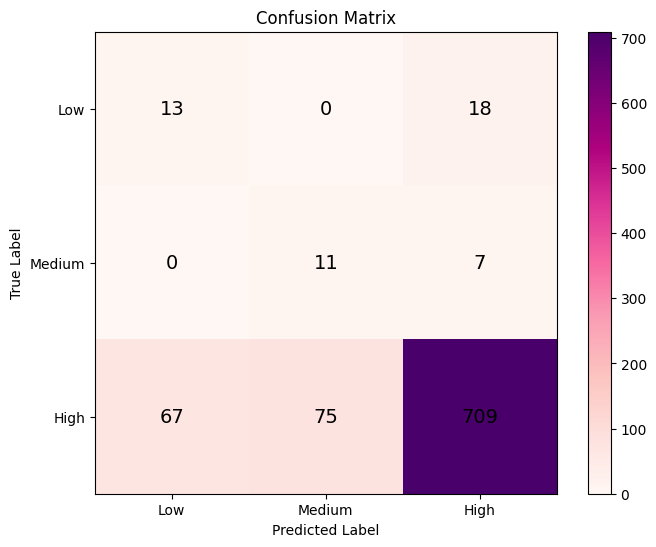

Accuracy of Multinomial Naïve Bayes: 0.8144444444444444


In [137]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test_m, y_pred_m)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='RdPu', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)  
plt.xticks(tick_marks, ['Low', 'Medium', 'High'])
plt.yticks(tick_marks, ['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotating the confusion matrix with values
for i in range(3): 
    for j in range(3): 
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Saving the plot
plt.savefig('confusion_matrix_multinomial.png')
plt.show()

# Print the accuracy
print("Accuracy of Multinomial Naïve Bayes:", accuracy_score(y_test_m, y_pred_m))



In [138]:
# Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X_train_g, y_train_g)
y_pred_g = gnb.predict(X_test_g)
print("\nGaussian Naïve Bayes Results (Cult Classic):")
print("Confusion Matrix:\n", confusion_matrix(y_test_g, y_pred_g))
print("Accuracy:", accuracy_score(y_test_g, y_pred_g))
print("Classification Report:\n", classification_report(y_test_g, y_pred_g))



Gaussian Naïve Bayes Results (Cult Classic):
Confusion Matrix:
 [[814  46]
 [ 12  28]]
Accuracy: 0.9355555555555556
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       860
           1       0.38      0.70      0.49        40

    accuracy                           0.94       900
   macro avg       0.68      0.82      0.73       900
weighted avg       0.96      0.94      0.94       900



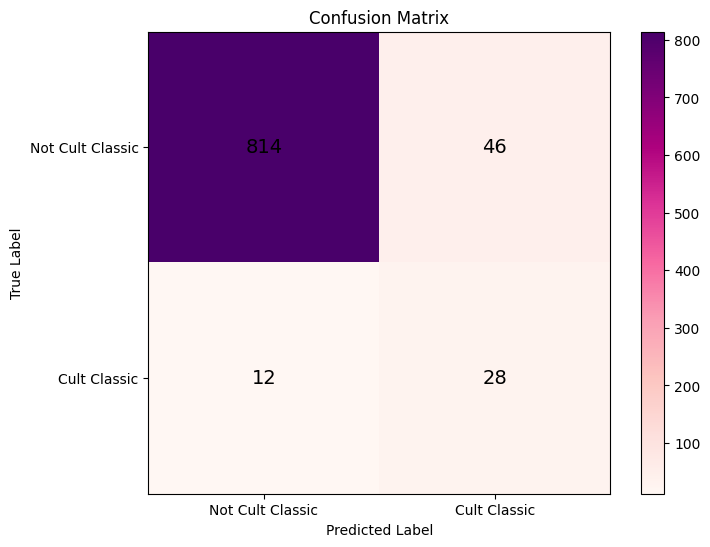

Accuracy of Gaussian Naïve Bayes: 0.9355555555555556


In [139]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test_g, y_pred_g)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='RdPu', interpolation='nearest')  
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2) 
plt.xticks(tick_marks, ['Not Cult Classic', 'Cult Classic'])
plt.yticks(tick_marks, ['Not Cult Classic', 'Cult Classic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotating the confusion matrix with values
for i in range(2):  
    for j in range(2):  
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Saving the plot
plt.savefig('confusion_matrix_gaussian.png')

plt.show()

# Print the accuracy
print("Accuracy of Gaussian Naïve Bayes:", accuracy_score(y_test_g, y_pred_g))


In [140]:
# Bernoulli Naïve Bayes
bnb = BernoulliNB()
bnb.fit(X_train_b, y_train_b)
y_pred_b = bnb.predict(X_test_b)
print("\nBernoulli Naïve Bayes Results (Game Night Game):")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))


Bernoulli Naïve Bayes Results (Game Night Game):
Confusion Matrix:
 [[  0 398]
 [  0 502]]
Accuracy: 0.5577777777777778
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       398
           1       0.56      1.00      0.72       502

    accuracy                           0.56       900
   macro avg       0.28      0.50      0.36       900
weighted avg       0.31      0.56      0.40       900



C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [141]:
from sklearn.utils import resample

# Combining features and target into one DataFrame for resampling
bernoulli_data = pd.DataFrame(X_train_b, columns=['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime'])
bernoulli_data['game_night_game'] = y_train_b

# Separating majority and minority classes
majority_class = bernoulli_data[bernoulli_data['game_night_game'] == 0]
minority_class = bernoulli_data[bernoulli_data['game_night_game'] == 1]

# Oversampling the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,         # sample with replacement
                                      n_samples=len(majority_class), # match number in majority class
                                      random_state=42)      # reproducible results

# Combining majority class with oversampled minority class
balanced_data = pd.concat([majority_class, minority_class_oversampled])

# Separating features and target for the balanced dataset
X_train_b_balanced = balanced_data.drop('game_night_game', axis=1).values
y_train_b_balanced = balanced_data['game_night_game'].values


In [142]:
# Bernoulli Naïve Bayes with balanced data
bnb = BernoulliNB(binarize=0.5)
bnb.fit(X_train_b_balanced, y_train_b_balanced)
y_pred_b = bnb.predict(X_test_b)
print("\nBernoulli Naïve Bayes Results (Game Night Game) with Balanced Data:")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))



Bernoulli Naïve Bayes Results (Game Night Game) with Balanced Data:
Confusion Matrix:
 [[  1 397]
 [  3 499]]
Accuracy: 0.5555555555555556
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.00      0.00       398
           1       0.56      0.99      0.71       502

    accuracy                           0.56       900
   macro avg       0.40      0.50      0.36       900
weighted avg       0.42      0.56      0.40       900



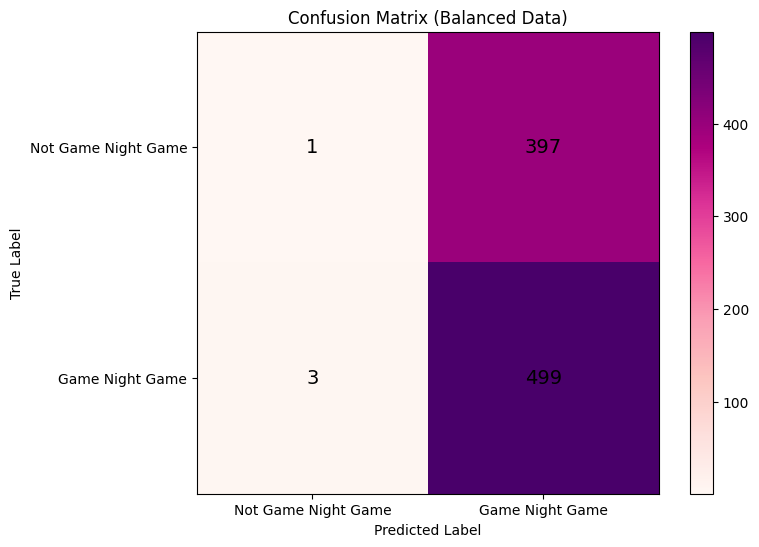

Accuracy of Bernoulli Naïve Bayes (Balanced Data): 0.5555555555555556


In [143]:
# Plotting the confusion matrix 
conf_matrix_b = confusion_matrix(y_test_b, y_pred_b)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_b, cmap='RdPu', interpolation='nearest')  # RdPu color map
plt.title('Confusion Matrix (Balanced Data)')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming two classes: 'Not Game Night Game' and 'Game Night Game'
plt.xticks(tick_marks, ['Not Game Night Game', 'Game Night Game'])
plt.yticks(tick_marks, ['Not Game Night Game', 'Game Night Game'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotating the confusion matrix with values
for i in range(2):  # Two classes: Game Night Game and Not Game Night Game
    for j in range(2):  # Two classes: Game Night Game and Not Game Night Game
        plt.text(j, i, str(conf_matrix_b[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Saving the plot
plt.savefig('confusion_matrix_bernoulli_balanced.png')

plt.show()

# Print the accuracy
print("Accuracy of Bernoulli Naïve Bayes (Balanced Data):", accuracy_score(y_test_b, y_pred_b))

### Alternative Bernoulli

In [144]:
# Bernoulli Naïve Bayes - Target: high_complexity_game
bernoulli_features = data[['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime']].values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    bernoulli_features, data['high_complexity_game'], test_size=0.3, random_state=42
)


In [145]:
# Bernoulli Naïve Bayes - High Complexity Game Prediction
bnb = BernoulliNB()
bnb.fit(X_train_b, y_train_b)
y_pred_b = bnb.predict(X_test_b)
print("\nBernoulli Naïve Bayes Results (High Complexity Game):")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))




Bernoulli Naïve Bayes Results (High Complexity Game):
Confusion Matrix:
 [[869   0]
 [ 31   0]]
Accuracy: 0.9655555555555555
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       869
           1       0.00      0.00      0.00        31

    accuracy                           0.97       900
   macro avg       0.48      0.50      0.49       900
weighted avg       0.93      0.97      0.95       900



C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [146]:
from sklearn.utils import resample

# Combining features and target into one DataFrame for resampling
bernoulli_data = pd.DataFrame(X_train_b, columns=['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime'])
bernoulli_data['high_complexity_game'] = y_train_b

# Separating classes
majority_class = bernoulli_data[bernoulli_data['high_complexity_game'] == 0]
minority_class = bernoulli_data[bernoulli_data['high_complexity_game'] == 1]

# Oversampling the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,         # sample with replacement
                                      n_samples=len(majority_class), # match number in majority class
                                      random_state=42)      # reproducible results

# Combining majority class with oversampled minority class
balanced_data = pd.concat([majority_class, minority_class_oversampled])

# Separating features and target for the balanced dataset
X_train_b_balanced = balanced_data.drop('high_complexity_game', axis=1).values
y_train_b_balanced = balanced_data['high_complexity_game'].values

# Bernoulli Naïve Bayes with balanced data
bnb = BernoulliNB()
bnb.fit(X_train_b_balanced, y_train_b_balanced)
y_pred_b = bnb.predict(X_test_b)
print("\nBernoulli Naïve Bayes Results (High Complexity Game) with Balanced Data:")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))



Bernoulli Naïve Bayes Results (High Complexity Game) with Balanced Data:
Confusion Matrix:
 [[865   4]
 [ 31   0]]
Accuracy: 0.9611111111111111
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       869
           1       0.00      0.00      0.00        31

    accuracy                           0.96       900
   macro avg       0.48      0.50      0.49       900
weighted avg       0.93      0.96      0.95       900



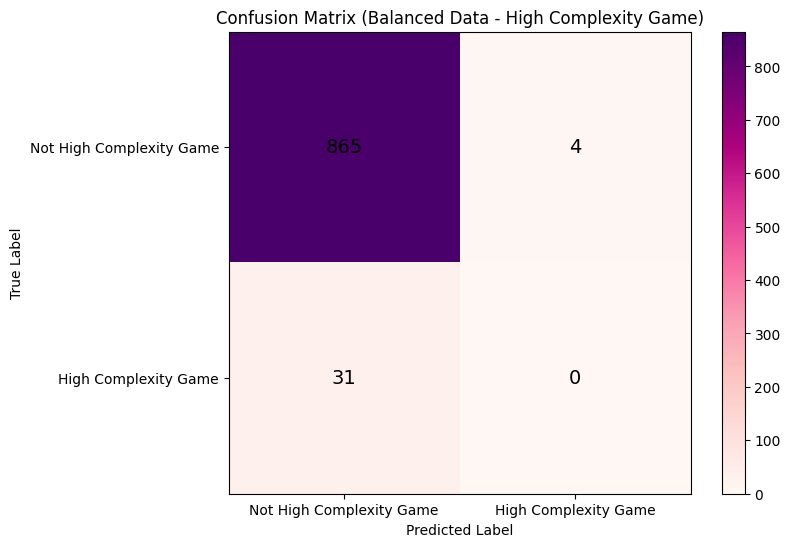

Accuracy of Bernoulli Naïve Bayes (Balanced Data - High Complexity Game): 0.9611111111111111


In [147]:
# Plotting the confusion matrix with RdPu color map
conf_matrix_b = confusion_matrix(y_test_b, y_pred_b)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_b, cmap='RdPu', interpolation='nearest')  
plt.title('Confusion Matrix (Balanced Data - High Complexity Game)')
plt.colorbar()
tick_marks = np.arange(2)  # Two classes: 'Not High Complexity Game' and 'High Complexity Game'
plt.xticks(tick_marks, ['Not High Complexity Game', 'High Complexity Game'])
plt.yticks(tick_marks, ['Not High Complexity Game', 'High Complexity Game'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotating the confusion matrix with values
for i in range(2):  # Two classes: High Complexity Game and Not High Complexity Game
    for j in range(2): 
        plt.text(j, i, str(conf_matrix_b[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Saving the plot
plt.savefig('confusion_matrix_bernoulli_balanced_high_complexity.png')

plt.show()

# Print the accuracy
print("Accuracy of Bernoulli Naïve Bayes (Balanced Data - High Complexity Game):", accuracy_score(y_test_b, y_pred_b))


In [148]:
# Bernoulli Naïve Bayes - Target: cult_classic
bernoulli_features = data[['weight', 'category_count', 'mechanic_count', 'min_players', 'max_players', 'min_playtime', 'max_playtime']].values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    bernoulli_features, data['cult_classic'], test_size=0.3, random_state=42
)

# Bernoulli Naïve Bayes
bnb = BernoulliNB()
bnb.fit(X_train_b, y_train_b)
y_pred_b = bnb.predict(X_test_b)

# Displaying results
print("\nBernoulli Naïve Bayes Results (Cult Classic - Original Data):")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))



Bernoulli Naïve Bayes Results (Cult Classic - Original Data):
Confusion Matrix:
 [[860   0]
 [ 40   0]]
Accuracy: 0.9555555555555556
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       860
           1       0.00      0.00      0.00        40

    accuracy                           0.96       900
   macro avg       0.48      0.50      0.49       900
weighted avg       0.91      0.96      0.93       900



C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i